<a href="https://colab.research.google.com/github/sakshivedi-1/Fashion_MNIST_neural_net/blob/main/Fashion_mnist_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installation and Import**

In [4]:
!pip install wandb -q
import wandb
wandb.login()

import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: msa24011 (msa24011-indian-institute-of-information-technology-lucknow) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# **Load Data**



In [5]:
(x_train,y_train), (x_test,y_test) = fashion_mnist.load_data()

class_names= ['T-shirt/top','Trouser','Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Plot sample image for each class**

Sample Images from Each Category:


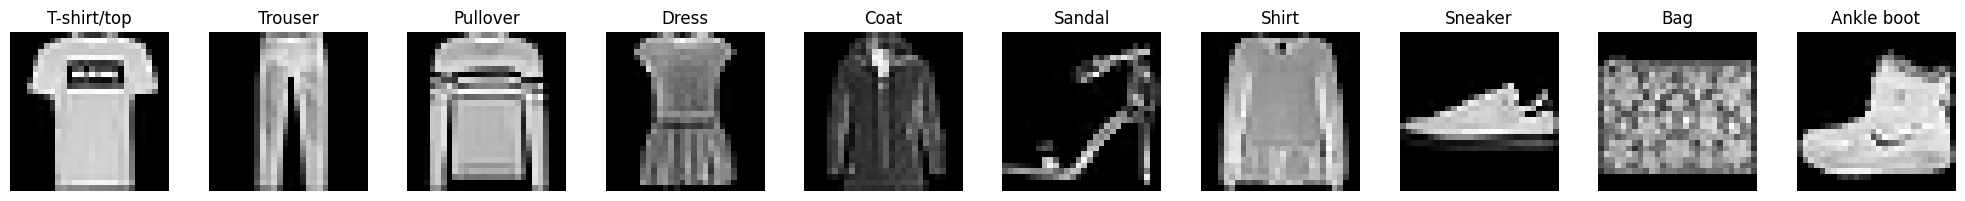

In [21]:
def display_sample_images(images, labels, class_names):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    unique_labels = np.unique(labels)

    for i, label in enumerate(unique_labels):
        sample_idx = np.where(labels == label)[0][0]
        axes[i].imshow(images[sample_idx], cmap='gray')
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Sample Images:")
display_sample_images(x_train, y_train, class_names)

# **Data preprocessing**

In [22]:
# Flatten images from 28x28 to 784-dimensional vectors and normalize to [0, 1]
X_train_flat = x_train.reshape(x_train.shape[0], -1) / 255.0
X_test_flat = x_test.reshape(x_test.shape[0], -1) / 255.0

In [24]:
#Split 10% for validation
val_size = int(0.1* X_train_flat.shape[0])

X_val = X_train_flat[:val_size]
y_val = y_train[:val_size]

X_train_final= X_train_flat[val_size:]
y_train_final= y_train[val_size:]

# **Forward propagation and backpropagation**

In [25]:
class NeuralNetwork:
    def __init__(self, layer_dims, activation='sigmoid', weight_init='random'):
        self.layer_dims = layer_dims
        self.activation = activation
        self.weights = {}

        # Initialize weights and biases
        np.random.seed(42)
        for idx in range(len(layer_dims) - 1):
            if weight_init == 'xavier':
                bound = np.sqrt(6 / (layer_dims[idx] + layer_dims[idx+1]))
                self.weights[f'W{idx+1}'] = np.random.uniform(-bound, bound, (layer_dims[idx], layer_dims[idx+1]))
            else:
                self.weights[f'W{idx+1}'] = np.random.randn(layer_dims[idx], layer_dims[idx+1]) * 0.01

            self.weights[f'b{idx+1}'] = np.zeros((1, layer_dims[idx+1]))

    def activate(self, Z):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
        elif self.activation == 'tanh':
            return np.tanh(Z)
        elif self.activation == 'relu':
            return np.maximum(0, Z)
        return Z

    def softmax(self, Z):
        exp_vals = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    def forward(self, X):
        self.memory = {'A0': X}
        num_layers = len(self.layer_dims) - 1

        for idx in range(1, num_layers):
            Z = np.dot(self.memory[f'A{idx-1}'], self.weights[f'W{idx}']) + self.weights[f'b{idx}']
            A = self.activate(Z)
            self.memory[f'Z{idx}'] = Z
            self.memory[f'A{idx}'] = A

        Z_out = np.dot(self.memory[f'A{num_layers-1}'], self.weights[f'W{num_layers}']) + self.weights[f'b{num_layers}']
        A_out = self.softmax(Z_out)
        self.memory[f'Z{num_layers}'] = Z_out
        self.memory[f'A{num_layers}'] = A_out
        return A_out

    def activation_grad(self, Z, A):
        if self.activation == 'sigmoid':
            return A * (1 - A)
        elif self.activation == 'tanh':
            return 1 - A**2
        elif self.activation == 'relu':
            return (Z > 0).astype(float)
        return 1

    def backward(self, Y_true, Y_pred, reg_lambda):
        batch_size = Y_true.shape[0]
        num_layers = len(self.layer_dims) - 1
        self.grads = {}

        dZ = Y_pred - Y_true

        self.grads[f'dW{num_layers}'] = (1/batch_size) * np.dot(self.memory[f'A{num_layers-1}'].T, dZ) + (reg_lambda * self.weights[f'W{num_layers}'])
        self.grads[f'db{num_layers}'] = (1/batch_size) * np.sum(dZ, axis=0, keepdims=True)

        for idx in range(num_layers-1, 0, -1):
            dA = np.dot(dZ, self.weights[f'W{idx+1}'].T)
            dZ = dA * self.activation_grad(self.memory[f'Z{idx}'], self.memory[f'A{idx}'])

            self.grads[f'dW{idx}'] = (1/batch_size) * np.dot(self.memory[f'A{idx-1}'].T, dZ) + (reg_lambda * self.weights[f'W{idx}'])
            self.grads[f'db{idx}'] = (1/batch_size) * np.sum(dZ, axis=0, keepdims=True)

    def update_weights(self, opt_method, learning_rate, iteration):
        if not hasattr(self, 'momentum'):
            self.momentum = {}
            self.velocity = {}
            for param in self.weights:
                self.momentum[param] = np.zeros_like(self.weights[param])
                self.velocity[param] = np.zeros_like(self.weights[param])

        beta_1, beta_2, epsilon = 0.9, 0.999, 1e-8

        for param in self.weights:
            gradient = self.grads[f'd{param}']

            if opt_method == 'sgd':
                self.weights[param] -= learning_rate * gradient

            elif opt_method == 'momentum':
                self.momentum[param] = beta_1 * self.momentum[param] + learning_rate * gradient
                self.weights[param] -= self.momentum[param]

            elif opt_method == 'nesterov':
                self.momentum[param] = beta_1 * self.momentum[param] + learning_rate * gradient
                self.weights[param] -= (beta_1 * self.momentum[param] + learning_rate * gradient)

            elif opt_method == 'rmsprop':
                self.velocity[param] = beta_2 * self.velocity[param] + (1 - beta_2) * gradient**2
                self.weights[param] -= learning_rate * gradient / (np.sqrt(self.velocity[param]) + epsilon)

            elif opt_method == 'adam':
                self.momentum[param] = beta_1 * self.momentum[param] + (1 - beta_1) * gradient
                self.velocity[param] = beta_2 * self.velocity[param] + (1 - beta_2) * gradient**2

                m_corrected = self.momentum[param] / (1 - beta_1**(iteration+1))
                v_corrected = self.velocity[param] / (1 - beta_2**(iteration+1))

                self.weights[param] -= learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)

            elif opt_method == 'nadam':
                self.momentum[param] = beta_1 * self.momentum[param] + (1 - beta_1) * gradient
                self.velocity[param] = beta_2 * self.velocity[param] + (1 - beta_2) * gradient**2

                m_corrected = self.momentum[param] / (1 - beta_1**(iteration+1))
                v_corrected = self.velocity[param] / (1 - beta_2**(iteration+1))

                m_nesterov = (beta_1 * m_corrected) + ((1 - beta_1) * gradient / (1 - beta_1**(iteration+1)))
                self.weights[param] -= learning_rate * m_nesterov / (np.sqrt(v_corrected) + epsilon)

In [26]:
def convert_to_one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

def train_model():
    # Start wandb tracking
    run = wandb.init()
    cfg = run.config

    # Create descriptive run name
    run.name = f"layers_{cfg.hidden_layers}_batch_{cfg.batch_size}_act_{cfg.activation}_opt_{cfg.optimizer}"

    # Build network architecture
    architecture = [784] + [cfg.hidden_size] * cfg.hidden_layers + [10]

    # Create neural network instance
    model = NeuralNetwork(architecture, activation=cfg.activation, weight_init=cfg.weight_init)

    # Training process
    total_samples = X_train_final.shape[0]
    for ep in range(cfg.epochs):
        # Shuffle training data
        shuffle_idx = np.arange(total_samples)
        np.random.shuffle(shuffle_idx)
        X_shuffled = X_train_final[shuffle_idx]
        y_shuffled = convert_to_one_hot(y_train_final[shuffle_idx])

        # Process mini-batches
        for batch_start in range(0, total_samples, cfg.batch_size):
            batch_end = batch_start + cfg.batch_size
            X_batch = X_shuffled[batch_start:batch_end]
            y_batch = y_shuffled[batch_start:batch_end]

            # Forward pass
            predictions = model.forward(X_batch)

            # Backward pass
            model.backward(y_batch, predictions, cfg.weight_decay)

            # Parameter update
            model.update_weights(cfg.optimizer, cfg.learning_rate, ep)

        # Evaluate on validation set
        val_predictions = model.forward(X_val)
        val_loss = -np.mean(np.sum(convert_to_one_hot(y_val) * np.log(val_predictions + 1e-8), axis=1))
        val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == y_val)

        # Check training accuracy on subset
        train_predictions = model.forward(X_train_final[:1000])
        train_accuracy = np.mean(np.argmax(train_predictions, axis=1) == y_train_final[:1000])

        # Log metrics
        wandb.log({
            "validation_loss": val_loss,
            "validation_accuracy": val_accuracy,
            "training_accuracy": train_accuracy,
            "epoch": ep
        })

        print(f"Epoch {ep} | Val Accuracy: {val_accuracy:.4f} | Loss: {val_loss:.4f}")

In [27]:
# Sweep configuration using Bayesian optimization for efficient hyperparameter search
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

In [28]:
# Initialize and run the hyperparameter sweep
sweep_id = wandb.sweep(sweep_config, project="Atri-Assignment-FashionMNIST")

# Run sweep with specified number of experiments
wandb.agent(sweep_id, train_model, count=15)

Create sweep with ID: jhpx4r4x
Sweep URL: https://wandb.ai/msa24011-indian-institute-of-information-technology-lucknow/Atri-Assignment-FashionMNIST/sweeps/jhpx4r4x


wandb: Agent Starting Run: z3fumums with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.7055 | Loss: 0.8352
Epoch 1 | Val Accuracy: 0.7853 | Loss: 0.5917
Epoch 2 | Val Accuracy: 0.7983 | Loss: 0.5313
Epoch 3 | Val Accuracy: 0.8290 | Loss: 0.4851
Epoch 4 | Val Accuracy: 0.8437 | Loss: 0.4606
Epoch 5 | Val Accuracy: 0.8488 | Loss: 0.4332
Epoch 6 | Val Accuracy: 0.8550 | Loss: 0.4149
Epoch 7 | Val Accuracy: 0.8565 | Loss: 0.4002
Epoch 8 | Val Accuracy: 0.8560 | Loss: 0.4075
Epoch 9 | Val Accuracy: 0.8647 | Loss: 0.3868


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▄▆▇▇████
validation_accuracy,▁▅▅▆▇▇████
validation_loss,█▄▃▃▂▂▁▁▁▁
epoch,9
training_accuracy,0.859
validation_accuracy,0.86467
validation_loss,0.38675


wandb: Agent Starting Run: krrdiwdk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.6928 | Loss: 0.8214
Epoch 1 | Val Accuracy: 0.7302 | Loss: 0.7318
Epoch 2 | Val Accuracy: 0.7705 | Loss: 0.6757
Epoch 3 | Val Accuracy: 0.7867 | Loss: 0.6331
Epoch 4 | Val Accuracy: 0.7977 | Loss: 0.6015
Epoch 5 | Val Accuracy: 0.8070 | Loss: 0.5775
Epoch 6 | Val Accuracy: 0.8102 | Loss: 0.5594
Epoch 7 | Val Accuracy: 0.8167 | Loss: 0.5440
Epoch 8 | Val Accuracy: 0.8192 | Loss: 0.5308
Epoch 9 | Val Accuracy: 0.8190 | Loss: 0.5228


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▇▇█████
validation_accuracy,▁▃▅▆▇▇████
validation_loss,█▆▅▄▃▂▂▁▁▁
epoch,9
training_accuracy,0.813
validation_accuracy,0.819
validation_loss,0.52278


wandb: Agent Starting Run: 7rr1hovw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.0983 | Loss: 2.3042
Epoch 1 | Val Accuracy: 0.0983 | Loss: 2.3046
Epoch 2 | Val Accuracy: 0.0983 | Loss: 2.3032
Epoch 3 | Val Accuracy: 0.0933 | Loss: 2.3035
Epoch 4 | Val Accuracy: 0.1028 | Loss: 2.3045
Epoch 5 | Val Accuracy: 0.0983 | Loss: 2.3045
Epoch 6 | Val Accuracy: 0.1020 | Loss: 2.3057
Epoch 7 | Val Accuracy: 0.0933 | Loss: 2.3044
Epoch 8 | Val Accuracy: 0.0983 | Loss: 2.3028
Epoch 9 | Val Accuracy: 0.0973 | Loss: 2.3033


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▆▆▆▃▁▆█▃▆▁
validation_accuracy,▅▅▅▁█▅▇▁▅▄
validation_loss,▅▅▂▃▅▅█▅▁▂
epoch,9
training_accuracy,0.087
validation_accuracy,0.09733
validation_loss,2.30335


wandb: Agent Starting Run: vffeoumf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.0933 | Loss: 2.3026
Epoch 1 | Val Accuracy: 0.0933 | Loss: 2.3026
Epoch 2 | Val Accuracy: 0.0933 | Loss: 2.3026
Epoch 3 | Val Accuracy: 0.0933 | Loss: 2.3026
Epoch 4 | Val Accuracy: 0.0933 | Loss: 2.3026
Epoch 5 | Val Accuracy: 0.0933 | Loss: 2.3026
Epoch 6 | Val Accuracy: 0.0933 | Loss: 2.3026
Epoch 7 | Val Accuracy: 0.0933 | Loss: 2.3027
Epoch 8 | Val Accuracy: 0.0933 | Loss: 2.3027
Epoch 9 | Val Accuracy: 0.0933 | Loss: 2.3027


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
validation_loss,▁▂▃▄▅▆▆▇██
epoch,9
training_accuracy,0.092
validation_accuracy,0.09333
validation_loss,2.30266


wandb: Agent Starting Run: cheyn9kb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.5047 | Loss: 1.9388
Epoch 1 | Val Accuracy: 0.5668 | Loss: 1.9699
Epoch 2 | Val Accuracy: 0.5608 | Loss: 2.0613
Epoch 3 | Val Accuracy: 0.5188 | Loss: 2.1493
Epoch 4 | Val Accuracy: 0.4693 | Loss: 2.2164
Epoch 5 | Val Accuracy: 0.3767 | Loss: 2.2597
Epoch 6 | Val Accuracy: 0.2762 | Loss: 2.2835
Epoch 7 | Val Accuracy: 0.1273 | Loss: 2.2947
Epoch 8 | Val Accuracy: 0.0990 | Loss: 2.2995
Epoch 9 | Val Accuracy: 0.0990 | Loss: 2.3014


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▇██▇▇▅▃▁▁▁
validation_accuracy,▇██▇▇▅▄▁▁▁
validation_loss,▁▂▃▅▆▇████
epoch,9
training_accuracy,0.105
validation_accuracy,0.099
validation_loss,2.30139


wandb: Agent Starting Run: 0xfdd80q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.4183 | Loss: 1.6517
Epoch 1 | Val Accuracy: 0.5363 | Loss: 1.2806
Epoch 2 | Val Accuracy: 0.6478 | Loss: 1.0983
Epoch 3 | Val Accuracy: 0.6642 | Loss: 0.9582
Epoch 4 | Val Accuracy: 0.7017 | Loss: 0.8676
Epoch 5 | Val Accuracy: 0.7188 | Loss: 0.8058
Epoch 6 | Val Accuracy: 0.7607 | Loss: 0.7575
Epoch 7 | Val Accuracy: 0.7767 | Loss: 0.7179
Epoch 8 | Val Accuracy: 0.7862 | Loss: 0.6825
Epoch 9 | Val Accuracy: 0.7938 | Loss: 0.6521


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇████
validation_accuracy,▁▃▅▆▆▇▇███
validation_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
training_accuracy,0.786
validation_accuracy,0.79383
validation_loss,0.65214


wandb: Agent Starting Run: hydeleo1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.7910 | Loss: 0.5870
Epoch 1 | Val Accuracy: 0.8167 | Loss: 0.5262
Epoch 2 | Val Accuracy: 0.8297 | Loss: 0.4910
Epoch 3 | Val Accuracy: 0.8337 | Loss: 0.4709
Epoch 4 | Val Accuracy: 0.8380 | Loss: 0.4571
Epoch 5 | Val Accuracy: 0.8463 | Loss: 0.4432
Epoch 6 | Val Accuracy: 0.8493 | Loss: 0.4338
Epoch 7 | Val Accuracy: 0.8538 | Loss: 0.4253
Epoch 8 | Val Accuracy: 0.8525 | Loss: 0.4221
Epoch 9 | Val Accuracy: 0.8560 | Loss: 0.4130


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▅▆▇▇▇▇█
validation_accuracy,▁▄▅▆▆▇▇███
validation_loss,█▆▄▃▃▂▂▁▁▁
epoch,9
training_accuracy,0.859
validation_accuracy,0.856
validation_loss,0.41299


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: squu5n3w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.7585 | Loss: 0.8447
Epoch 1 | Val Accuracy: 0.7828 | Loss: 0.7170
Epoch 2 | Val Accuracy: 0.7962 | Loss: 0.6517
Epoch 3 | Val Accuracy: 0.8030 | Loss: 0.6103
Epoch 4 | Val Accuracy: 0.8130 | Loss: 0.5814
Epoch 5 | Val Accuracy: 0.8192 | Loss: 0.5571
Epoch 6 | Val Accuracy: 0.8242 | Loss: 0.5392
Epoch 7 | Val Accuracy: 0.8255 | Loss: 0.5247
Epoch 8 | Val Accuracy: 0.8278 | Loss: 0.5122
Epoch 9 | Val Accuracy: 0.8285 | Loss: 0.5027


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▅▆▆▇▇█
validation_accuracy,▁▃▅▅▆▇████
validation_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
training_accuracy,0.82
validation_accuracy,0.8285
validation_loss,0.50267


wandb: Agent Starting Run: j4hzoq6f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.8073 | Loss: 0.5694
Epoch 1 | Val Accuracy: 0.8278 | Loss: 0.5073
Epoch 2 | Val Accuracy: 0.8393 | Loss: 0.4771
Epoch 3 | Val Accuracy: 0.8402 | Loss: 0.4652
Epoch 4 | Val Accuracy: 0.8508 | Loss: 0.4438
Epoch 5 | Val Accuracy: 0.8523 | Loss: 0.4331
Epoch 6 | Val Accuracy: 0.8557 | Loss: 0.4246
Epoch 7 | Val Accuracy: 0.8562 | Loss: 0.4218
Epoch 8 | Val Accuracy: 0.8583 | Loss: 0.4103
Epoch 9 | Val Accuracy: 0.8633 | Loss: 0.4058


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▇▇███
validation_accuracy,▁▄▅▅▆▇▇▇▇█
validation_loss,█▅▄▄▃▂▂▂▁▁
epoch,9
training_accuracy,0.861
validation_accuracy,0.86333
validation_loss,0.40576


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qw9zxcv6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.2915 | Loss: 2.2103
Epoch 1 | Val Accuracy: 0.2875 | Loss: 2.0420
Epoch 2 | Val Accuracy: 0.3185 | Loss: 1.8781
Epoch 3 | Val Accuracy: 0.3417 | Loss: 1.7503
Epoch 4 | Val Accuracy: 0.4685 | Loss: 1.6466
Epoch 5 | Val Accuracy: 0.4977 | Loss: 1.5605
Epoch 6 | Val Accuracy: 0.4903 | Loss: 1.4879
Epoch 7 | Val Accuracy: 0.5073 | Loss: 1.4249
Epoch 8 | Val Accuracy: 0.5098 | Loss: 1.3681
Epoch 9 | Val Accuracy: 0.5133 | Loss: 1.3180


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▂▃▇█▇███
validation_accuracy,▁▁▂▃▇█▇███
validation_loss,█▇▅▄▄▃▂▂▁▁
epoch,9
training_accuracy,0.52
validation_accuracy,0.51333
validation_loss,1.31802


wandb: Agent Starting Run: ex5n4whs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.8260 | Loss: 0.5027
Epoch 1 | Val Accuracy: 0.8378 | Loss: 0.4605
Epoch 2 | Val Accuracy: 0.8468 | Loss: 0.4319
Epoch 3 | Val Accuracy: 0.8570 | Loss: 0.4094
Epoch 4 | Val Accuracy: 0.8572 | Loss: 0.4045
Epoch 5 | Val Accuracy: 0.8602 | Loss: 0.3942
Epoch 6 | Val Accuracy: 0.8652 | Loss: 0.3867
Epoch 7 | Val Accuracy: 0.8655 | Loss: 0.3800
Epoch 8 | Val Accuracy: 0.8657 | Loss: 0.3768
Epoch 9 | Val Accuracy: 0.8647 | Loss: 0.3783


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▆▅▆▇██▇
validation_accuracy,▁▃▅▆▆▇████
validation_loss,█▆▄▃▃▂▂▁▁▁
epoch,9
training_accuracy,0.869
validation_accuracy,0.86467
validation_loss,0.37832


wandb: Agent Starting Run: tru4a7hq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.8262 | Loss: 0.5012
Epoch 1 | Val Accuracy: 0.8375 | Loss: 0.4593
Epoch 2 | Val Accuracy: 0.8473 | Loss: 0.4334
Epoch 3 | Val Accuracy: 0.8568 | Loss: 0.4108
Epoch 4 | Val Accuracy: 0.8570 | Loss: 0.4057


epoch,▁▃▅▆█
training_accuracy,▁▃▆█▇
validation_accuracy,▁▄▆██
validation_loss,█▅▃▁▁
epoch,4
training_accuracy,0.857
validation_accuracy,0.857
validation_loss,0.40574


wandb: Agent Starting Run: 32ith2nn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.8237 | Loss: 0.5091
Epoch 1 | Val Accuracy: 0.8423 | Loss: 0.4547
Epoch 2 | Val Accuracy: 0.8512 | Loss: 0.4297
Epoch 3 | Val Accuracy: 0.8538 | Loss: 0.4176
Epoch 4 | Val Accuracy: 0.8582 | Loss: 0.4120
Epoch 5 | Val Accuracy: 0.8593 | Loss: 0.4003
Epoch 6 | Val Accuracy: 0.8630 | Loss: 0.3932
Epoch 7 | Val Accuracy: 0.8635 | Loss: 0.3863
Epoch 8 | Val Accuracy: 0.8648 | Loss: 0.3784
Epoch 9 | Val Accuracy: 0.8665 | Loss: 0.3721


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▄▅▅▆▆▆█
validation_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▅▄▃▃▂▂▂▁▁
epoch,9
training_accuracy,0.883
validation_accuracy,0.8665
validation_loss,0.37214


wandb: Agent Starting Run: 5kucxrdb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.8340 | Loss: 0.4691
Epoch 1 | Val Accuracy: 0.8460 | Loss: 0.4335
Epoch 2 | Val Accuracy: 0.8552 | Loss: 0.4099
Epoch 3 | Val Accuracy: 0.8572 | Loss: 0.3947
Epoch 4 | Val Accuracy: 0.8593 | Loss: 0.3881


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
validation_accuracy,▁▄▇▇█
validation_loss,█▅▃▂▁
epoch,4
training_accuracy,0.861
validation_accuracy,0.85933
validation_loss,0.3881


wandb: Agent Starting Run: uj6ea8e5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 0 | Val Accuracy: 0.8192 | Loss: 0.5219
Epoch 1 | Val Accuracy: 0.8353 | Loss: 0.4749
Epoch 2 | Val Accuracy: 0.8478 | Loss: 0.4476
Epoch 3 | Val Accuracy: 0.8497 | Loss: 0.4356
Epoch 4 | Val Accuracy: 0.8530 | Loss: 0.4236
Epoch 5 | Val Accuracy: 0.8557 | Loss: 0.4152
Epoch 6 | Val Accuracy: 0.8572 | Loss: 0.4083
Epoch 7 | Val Accuracy: 0.8580 | Loss: 0.4028
Epoch 8 | Val Accuracy: 0.8642 | Loss: 0.3933
Epoch 9 | Val Accuracy: 0.8600 | Loss: 0.3903


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▅▇▆▆▇██
validation_accuracy,▁▄▅▆▆▇▇▇█▇
validation_loss,█▆▄▃▃▂▂▂▁▁
epoch,9
training_accuracy,0.87
validation_accuracy,0.86
validation_loss,0.39032


Training with optimal configuration: {'epochs': 20, 'hidden_layers': 5, 'hidden_size': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 64, 'weight_init': 'xavier', 'weight_decay': 0.0005}
Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.
Evaluating on test set...
Test Set Accuracy: 87.82%


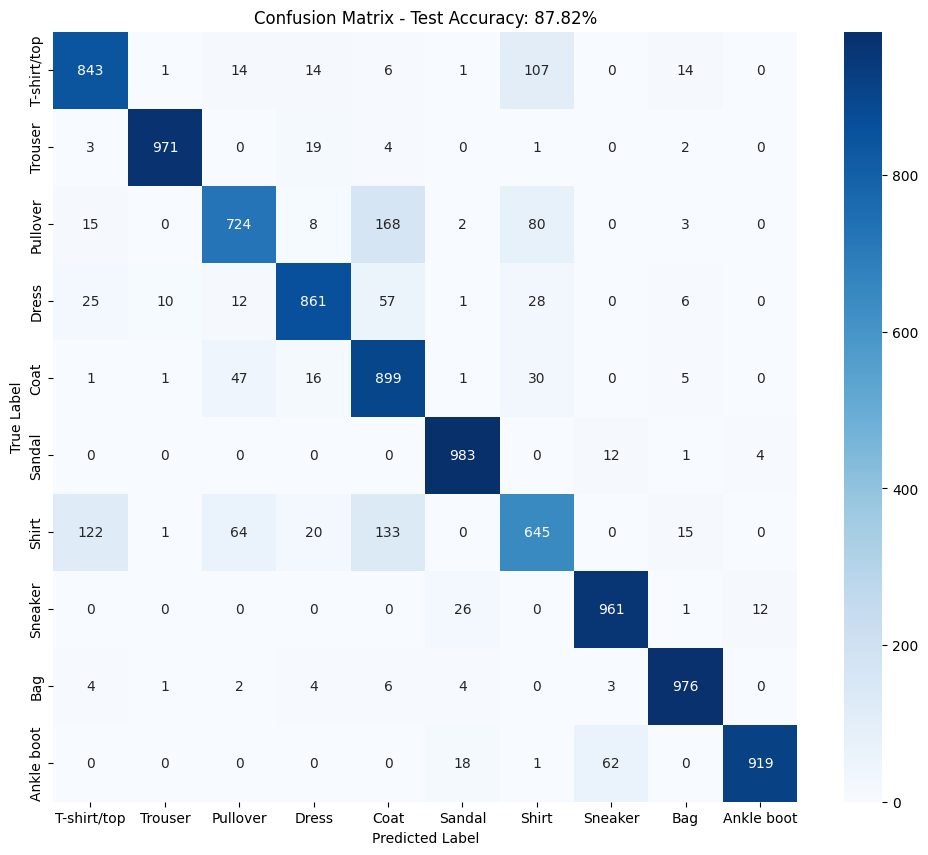

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def convert_to_one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# Best hyperparameters identified from sweep
optimal_config = {
    'epochs': 20,              # More epochs
    'hidden_layers': 5,        # Deep network
    'hidden_size': 128,        # Wide layers
    'activation': 'relu',      # Best activation
    'optimizer': 'adam',       # Best optimizer
    'learning_rate': 0.001,    # Standard Adam LR
    'batch_size': 64,          # Good balance
    'weight_init': 'xavier',   # Proper initialization
    'weight_decay': 0.0005     # Light regularization
}

print(f"Training with optimal configuration: {optimal_config}")

# Build network architecture
network_structure = [784] + [optimal_config['hidden_size']] * optimal_config['hidden_layers'] + [10]

# Initialize best model
best_model = NeuralNetwork(
    network_structure,
    activation=optimal_config['activation'],
    weight_init=optimal_config['weight_init']
)

# Training phase
total_samples = X_train_final.shape[0]

for ep in range(optimal_config['epochs']):
    # Shuffle training data
    idx = np.arange(total_samples)
    np.random.shuffle(idx)
    X_shuffled = X_train_final[idx]
    y_shuffled = convert_to_one_hot(y_train_final[idx])

    # Process batches
    for start in range(0, total_samples, optimal_config['batch_size']):
        end = start + optimal_config['batch_size']
        X_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]

        # Forward propagation
        predictions = best_model.forward(X_batch)

        # Backpropagation
        best_model.backward(y_batch, predictions, optimal_config['weight_decay'])

        # Weight update
        best_model.update_weights(optimal_config['optimizer'], optimal_config['learning_rate'], ep)

    print(f"Epoch {ep+1}/{optimal_config['epochs']} completed.")

# Test set evaluation
print("Evaluating on test set...")
test_predictions = best_model.forward(X_test_flat)
y_pred = np.argmax(test_predictions, axis=1)
y_true = y_test

# Calculate test accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - Test Accuracy: {accuracy*100:.2f}%')
plt.show()

Comparing Cross-Entropy Loss vs Mean Squared Error Loss...
Training with CROSS_ENTROPY loss...
Training with MSE loss...


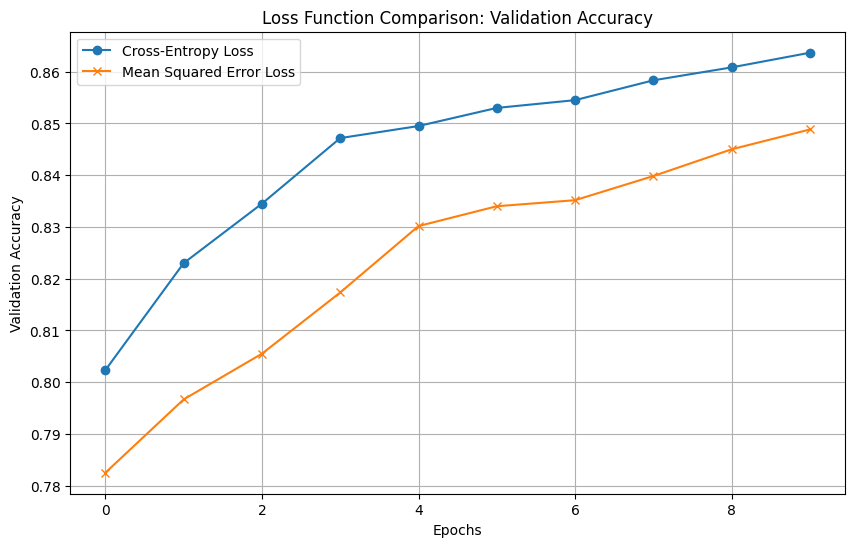

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def compare_loss_functions():
    print("Comparing Cross-Entropy Loss vs Mean Squared Error Loss...")

    # Training parameters
    num_epochs = 10
    batch_size = 64
    learning_rate = 0.001

    # Store training results
    results = {'cross_entropy': [], 'mse': []}

    # Train with both loss functions
    for loss_func in ['cross_entropy', 'mse']:
        print(f"Training with {loss_func.upper()} loss...")

        # Create new network for fair comparison
        model = NeuralNetwork([784, 64, 32, 10], activation='sigmoid', weight_init='xavier')

        # Track accuracy per epoch
        epoch_accuracies = []

        for ep in range(num_epochs):
            # Shuffle data
            idx = np.arange(X_train_final.shape[0])
            np.random.shuffle(idx)
            X_shuffled = X_train_final[idx]
            y_shuffled = convert_to_one_hot(y_train_final[idx])

            for start in range(0, X_train_final.shape[0], batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                batch_samples = y_batch.shape[0]

                # Forward pass
                predictions = model.forward(X_batch)

                # Backward pass with different loss gradients
                model.grads = {}
                num_layers = len(model.layer_dims) - 1

                # Loss-specific gradient computation
                if loss_func == 'cross_entropy':
                    dZ = predictions - y_batch
                else:
                    # MSE gradient with softmax
                    dZ = (predictions - y_batch) * (predictions * (1 - predictions))

                # Output layer gradients
                model.grads[f'dW{num_layers}'] = (1/batch_samples) * np.dot(model.memory[f'A{num_layers-1}'].T, dZ)
                model.grads[f'db{num_layers}'] = (1/batch_samples) * np.sum(dZ, axis=0, keepdims=True)

                # Hidden layer gradients
                for layer_idx in range(num_layers-1, 0, -1):
                    dA = np.dot(dZ, model.weights[f'W{layer_idx+1}'].T)

                    # Activation derivative
                    if model.activation == 'sigmoid':
                        activation_grad = model.memory[f'A{layer_idx}'] * (1 - model.memory[f'A{layer_idx}'])
                    elif model.activation == 'tanh':
                        activation_grad = 1 - model.memory[f'A{layer_idx}']**2
                    elif model.activation == 'relu':
                        activation_grad = (model.memory[f'Z{layer_idx}'] > 0).astype(float)

                    dZ = dA * activation_grad

                    model.grads[f'dW{layer_idx}'] = (1/batch_samples) * np.dot(model.memory[f'A{layer_idx-1}'].T, dZ)
                    model.grads[f'db{layer_idx}'] = (1/batch_samples) * np.sum(dZ, axis=0, keepdims=True)

                # Update weights
                model.update_weights('adam', learning_rate, ep)

            # Evaluate on validation set
            val_predictions = model.forward(X_val)
            val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == y_val)
            epoch_accuracies.append(val_accuracy)

        results[loss_func] = epoch_accuracies

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(results['cross_entropy'], label='Cross-Entropy Loss', marker='o')
    plt.plot(results['mse'], label='Mean Squared Error Loss', marker='x')
    plt.title('Loss Function Comparison: Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute comparison
compare_loss_functions()